In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

from scipy.optimize import curve_fit


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

2023-02-03 16:01:18.726936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 16:01:18.900657: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-03 16:01:19.748833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-02-03 16:01:19.749021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [2]:
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
truth_tau_pt = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:])
reco_tau_pt = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[400000:])

#Load model and select out the tau
model = load_model('../models/L1Tau_Jan_25_2023_pTShape_v4_PtTruthCut.h5')

#Get all the inputs
sig_input = np.asarray(sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:])

pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['pt'].array()[400000:])
deltaR_sig = np.asarray(sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:])
eta_sig = np.asarray(sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:])

selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

#Selected out the tau pt with the basic cuts first
truth_tau_pt_select = truth_tau_pt[selection_sig]
reco_tau_pt_select = reco_tau_pt[selection_sig]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[400000:][selection_sig])
tau_pt_old_nn = reco_tau_pt_select[old_tau_select == 1]
old_nn_score = np.asarray(sig['ntuplePupSingle']['tree']['chargedIso'].array()[400000:][selection_sig])

2023-02-03 16:01:21.930127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 16:01:23.274389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 500 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2023-02-03 16:01:23.276145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21314 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
X_sig = np.asarray(sig_input[selection_sig])
X_sig[abs(X_sig) > 1e+4] = 0.
y_sig = model.predict(np.nan_to_num(X_sig))

  95/1405 [=>............................] - ETA: 2s

2023-02-03 16:01:26.244678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1405/1405 [==============================] - 3s 1ms/step


In [4]:
def score_transform(iso, pt):
    
    PFTAU_NN_OFFSET = 0.46326069
    PFTAU_NN_SLOPE = 0.00054092
    PFTAU_NN_OVERALL_SCALE = 1./8.

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE/(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))
    
#     popt = np.array([-6.91988326e-05,  1.13199839e-02, -7.35916692e-02])
    
#     a = popt[0]
#     b = popt[1]
#     c = popt[2]
    
#     PFTAU_NN_OVERALL_SCALE = 1./10.

#     PFTAU_NN_PT_CUTOFF = 100.0
    
#     x = np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))
    
#     #(a*np.log(b*np.minimum(pt,np.asarray(PFTAU_NN_PT_CUTOFF))) + c)
    
#     return iso*PFTAU_NN_OVERALL_SCALE/(a*(x**2) + b*x + c)


In [5]:
y_transform = score_transform(y_sig.flatten(),reco_tau_pt_select)

In [6]:
pT_egdes = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,200,250,2000]
mean_pt = []

mean_score_80_NoT = []
mean_score_90_NoT = []
mean_score_95_NoT = []

for i in range(len(pT_egdes) - 1):
    print("pt range: {} to {}".format(pT_egdes[i],pT_egdes[i+1]))
    mean_pt.append((pT_egdes[i] + pT_egdes[i+1])/2)
    
    y_sig_select = y_sig[(reco_tau_pt_select > pT_egdes[i]) & (reco_tau_pt_select < pT_egdes[i+1])]
    
    mean_score_80_NoT.append(np.percentile(y_sig_select,20))
    mean_score_90_NoT.append(np.percentile(y_sig_select,10))
    mean_score_95_NoT.append(np.percentile(y_sig_select,5))

pt range: 20 to 25
pt range: 25 to 30
pt range: 30 to 35
pt range: 35 to 40
pt range: 40 to 45
pt range: 45 to 50
pt range: 50 to 55
pt range: 55 to 60
pt range: 60 to 70
pt range: 70 to 80
pt range: 80 to 100
pt range: 100 to 125
pt range: 125 to 150
pt range: 150 to 200
pt range: 200 to 250
pt range: 250 to 2000


In [7]:
pT_egdes = [20,25,30,35,40,45,50,55,60,70,80,100,125,150,200,250,2000]
mean_pt = []

mean_score_80 = []
mean_score_90 = []
mean_score_95 = []

for i in range(len(pT_egdes) - 1):
    print("pt range: {} to {}".format(pT_egdes[i],pT_egdes[i+1]))
    mean_pt.append((pT_egdes[i] + pT_egdes[i+1])/2)
    
    y_sig_select = y_transform[(reco_tau_pt_select > pT_egdes[i]) & (reco_tau_pt_select < pT_egdes[i+1])]
    
    mean_score_80.append(np.percentile(y_sig_select,20))
    mean_score_90.append(np.percentile(y_sig_select,10))
    mean_score_95.append(np.percentile(y_sig_select,5))

pt range: 20 to 25
pt range: 25 to 30
pt range: 30 to 35
pt range: 35 to 40
pt range: 40 to 45
pt range: 45 to 50
pt range: 50 to 55
pt range: 55 to 60
pt range: 60 to 70
pt range: 70 to 80
pt range: 80 to 100
pt range: 100 to 125
pt range: 125 to 150
pt range: 150 to 200
pt range: 200 to 250
pt range: 250 to 2000


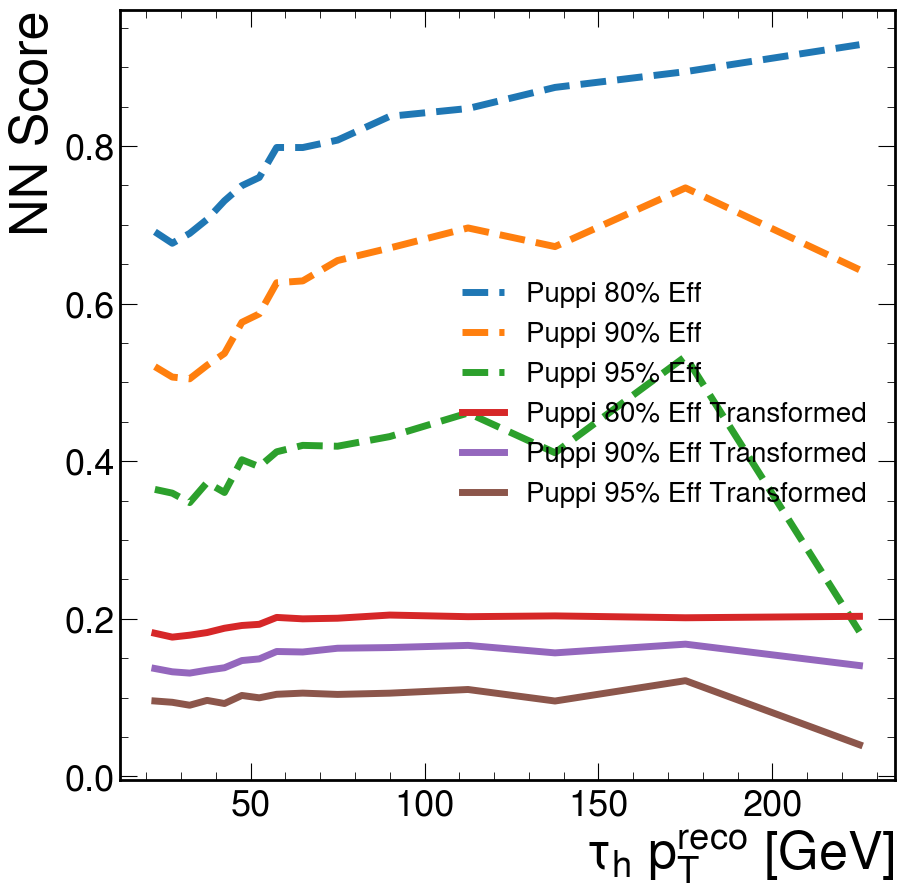

In [9]:
plt.plot(mean_pt[:15], mean_score_80_NoT[:15], linestyle = '--', label='Puppi 80% Eff')
plt.plot(mean_pt[:15], mean_score_90_NoT[:15], linestyle = '--', label='Puppi 90% Eff')
plt.plot(mean_pt[:15], mean_score_95_NoT[:15], linestyle = '--', label='Puppi 95% Eff')

plt.plot(mean_pt[:15], mean_score_80[:15], label='Puppi 80% Eff Transformed')
plt.plot(mean_pt[:15], mean_score_90[:15], label='Puppi 90% Eff Transformed')
plt.plot(mean_pt[:15], mean_score_95[:15], label='Puppi 95% Eff Transformed')

plt.xlabel(r"$\tau_h$ $p_T^{reco}$ [GeV]")
plt.ylabel("NN Score")
#plt.ylim([0,0.8])
plt.legend(fontsize=20)
plt.show()

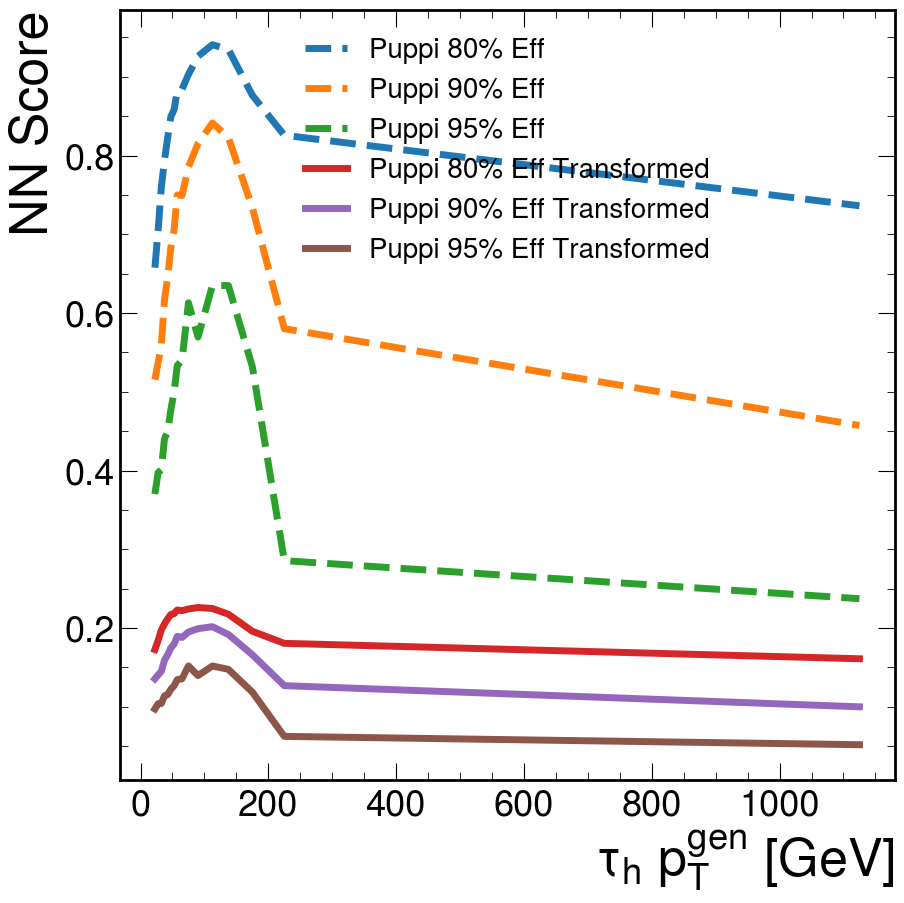

In [14]:
plt.plot(mean_pt, mean_score_80_NoT, linestyle = '--', label='Puppi 80% Eff')
plt.plot(mean_pt, mean_score_90_NoT, linestyle = '--', label='Puppi 90% Eff')
plt.plot(mean_pt, mean_score_95_NoT, linestyle = '--', label='Puppi 95% Eff')

plt.plot(mean_pt, mean_score_80, label='Puppi 80% Eff Transformed')
plt.plot(mean_pt, mean_score_90, label='Puppi 90% Eff Transformed')
plt.plot(mean_pt, mean_score_95, label='Puppi 95% Eff Transformed')

plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
plt.ylabel("NN Score")
#plt.ylim([0,0.8])
plt.legend(fontsize=20)
plt.show()

In [15]:
# def func(x,a,b,c):
#     return a*np.log(b*x) + c

def func(x,a,b):
    #a - (b*x+c)**2
    return a*x + b

popt, pcov = curve_fit(func, mean_pt[:15], mean_score_95_NoT[:15])

In [16]:
mean_pt[:17]

[22.5,
 27.5,
 32.5,
 37.5,
 42.5,
 47.5,
 52.5,
 57.5,
 65.0,
 75.0,
 90.0,
 112.5,
 137.5,
 175.0,
 225.0,
 300.0,
 375.0]

In [17]:
def func_2(x,a,b,c):
    return 1/(a*np.log(b*x) + c)

In [18]:
popt

array([-0.00054092,  0.46326069])

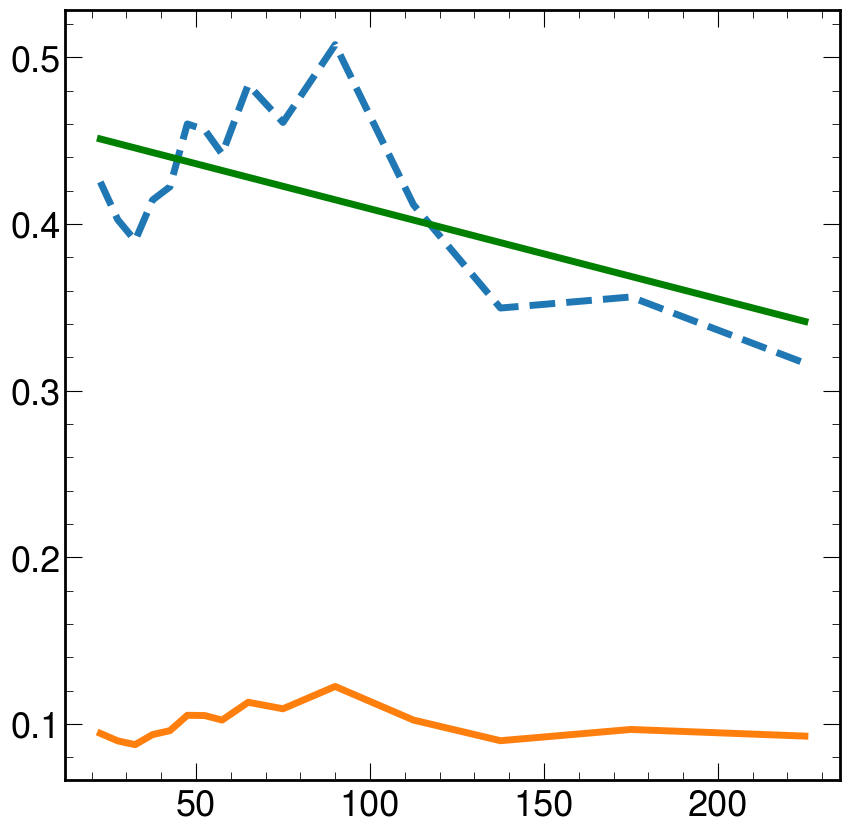

In [19]:
plt.plot(mean_pt[:15], mean_score_95_NoT[:15], linestyle = '--', label='Puppi 95% Eff')
plt.plot(mean_pt[:15], func(np.asarray(mean_pt[:15]), *popt), 'g-')
plt.plot(mean_pt[:15], mean_score_95_NoT[:15]/(func(np.asarray(mean_pt[:15]), *popt)*np.asarray(10)))
#plt.ylim([0,2])

## Efficiency

In [16]:
y_sig = y_transform

In [17]:
nn_cut = y_sig.flatten() > 0.05

In [18]:
tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[:400000][selection_sig])
tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150, 200]
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(truth_tau_pt_select)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150, 200], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 81071.0 (81816.0 with flow)

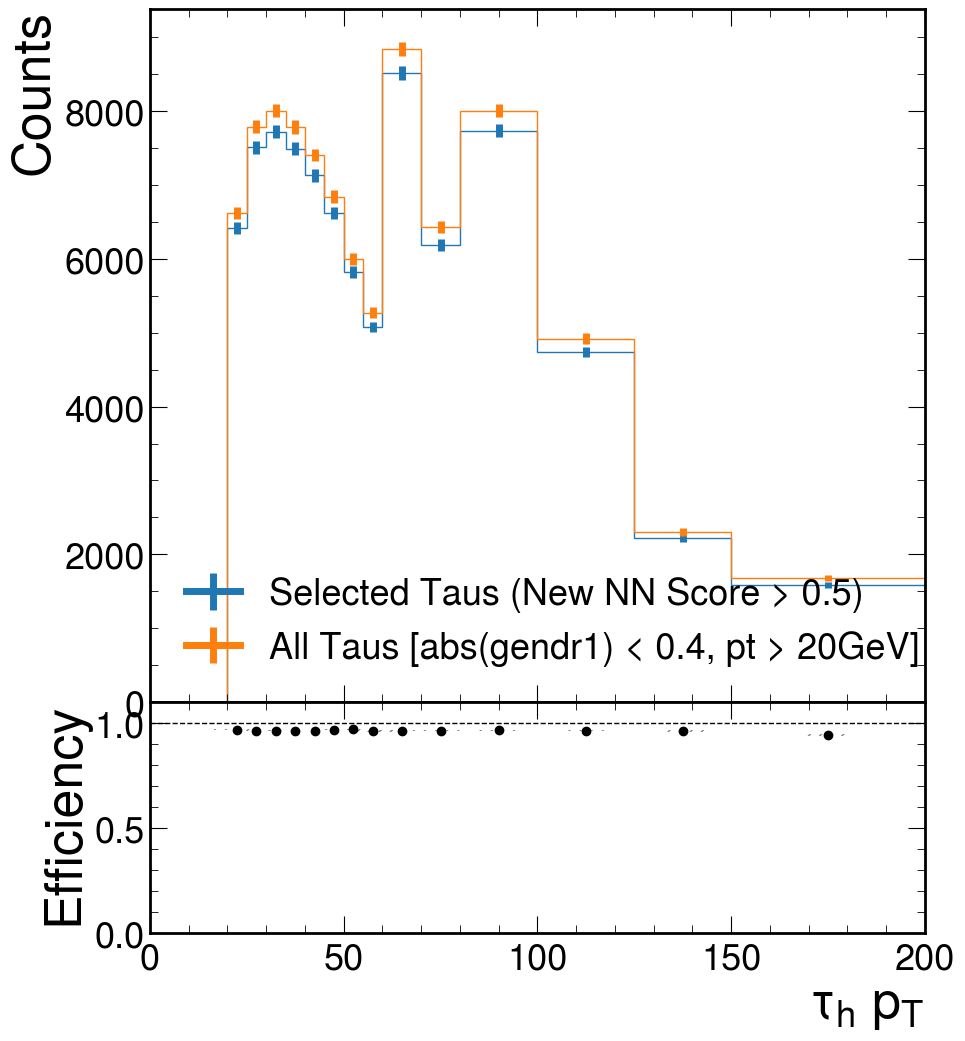

In [19]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (New NN Score > 0.5)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

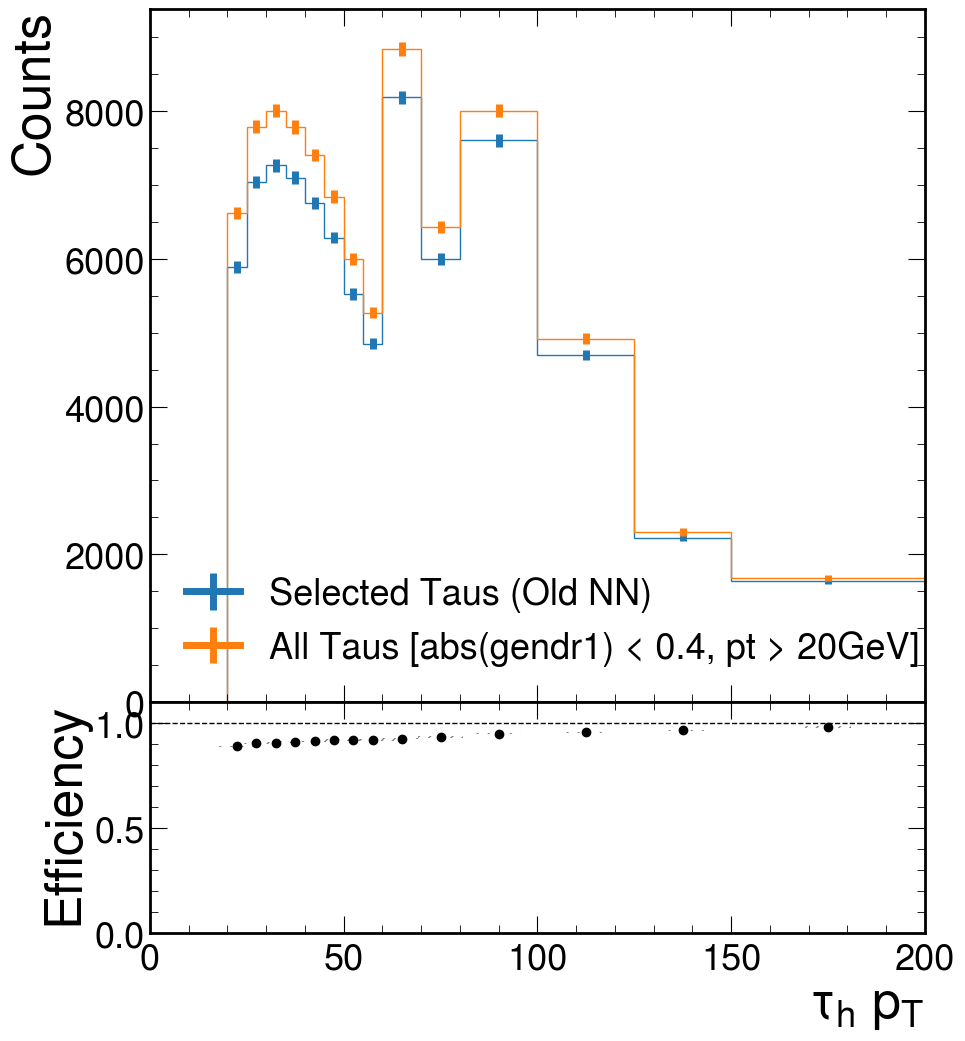

In [20]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

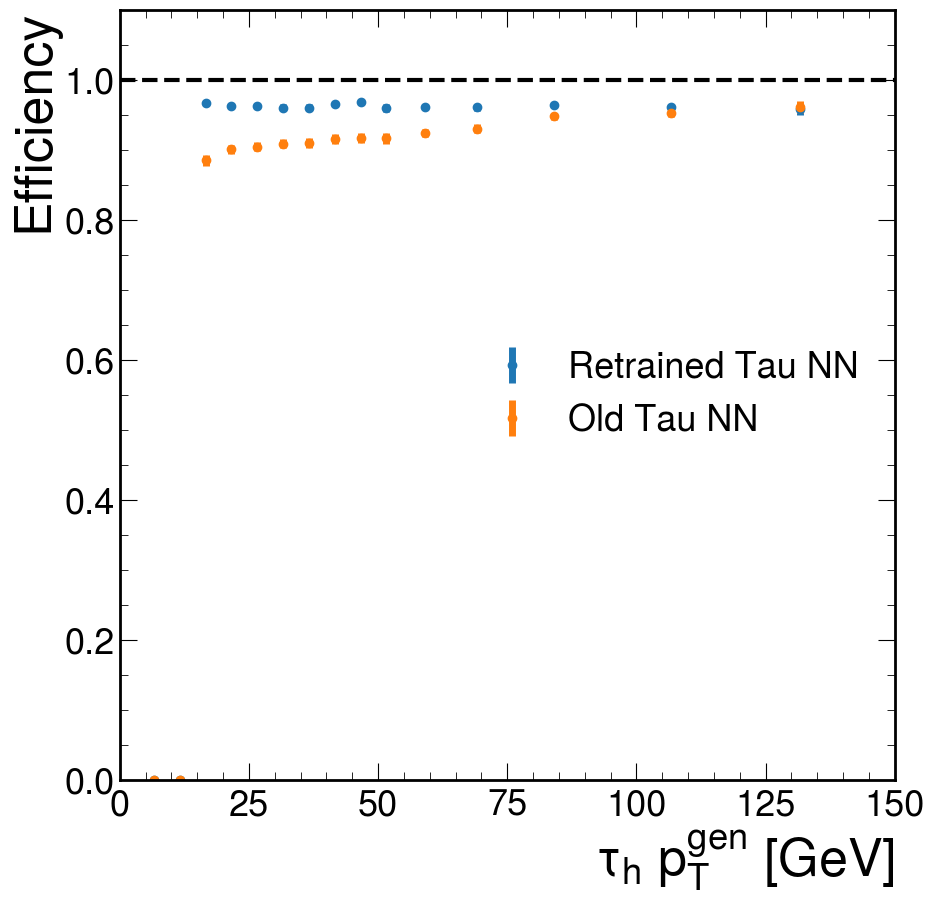

In [21]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()

# Fit a function on this